# Starbucks Promotion Analysis Vol.1/2


 
## Direction of this project


In this project, I will create a predictive model to predict whether a customer would complete a coupon or not **when they first view it**. 

This model is made by users who don't have any null value in their attributes, and also users who viewed BOGO or discount coupons at least 3 times.


(Even though a customer does not view or display the coupon in the shop, the coupon can be automatically completed once he spends the amount needed.)

This model uses mainly 3 kinds of features for prediction.

1. Coupon's info
2. Customer's attribute
3. Customer's past behavior to coupons
4. Situation when the customer viewed a coupon


## Table of contents
* Notebook vol.1

```
1. Load in files
2. Clean the data
3. Univariate Exploration
4. Multivariate Exploration
5. Make a dataframe whose each row represents each coupon sent in this observation period
6. Basic Feature Engineering
```

* Notebook vol.2   

```
1. Load in files
2. Feature engineering 1 (make columns representing the distribution of customer's past viewing time for coupons)
3. Feature engineering 2 (make a column representing the customer's past total completion rate)
4. Feature engineering 3 (make columns representing the customer's past total completion rate in 4 situation)
5. Create a model
6. Interpretation of the model
```


## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# 1. Load in files

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

pd.options.display.max_rows = 100
pd.set_option("display.max_columns", 500)

# 2. Clean the data

## (1)Portfolio

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## (2)Profile

In [3]:
# copy the dataframes
profile2 = profile.copy()

In [4]:
print(profile2.shape)
profile2.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# replace 118 in age column with nan
profile2.age = profile.age.replace(118, np.nan)

# convert "became_member_on" column to datetime type
profile2.became_member_on = pd.to_datetime(profile2.became_member_on, format="%Y%m%d")

# one_hot_encode "gender" column
profile2 = profile2.join(pd.get_dummies(profile2.gender,prefix="gender",dummy_na=True))
profile2 = profile2.drop("gender", axis = 1)

In [6]:
# replace values in "gender_F","gender_M","gender_O" clumns with nan if the gender is not unclear
for i, if_nan in enumerate(profile2.gender_nan):
    if if_nan == 1:
        profile2.loc[i, "gender_F"] = np.nan
        profile2.loc[i, "gender_M"] = np.nan
        profile2.loc[i, "gender_O"] = np.nan
profile2 = profile2.drop("gender_nan", 1)

In [7]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
age                 14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
id                  17000 non-null object
income              14825 non-null float64
gender_F            14825 non-null float64
gender_M            14825 non-null float64
gender_O            14825 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 929.8+ KB


In [8]:
# the numbere of customers whose ALL of age, income, gender are missed. 
print((profile2.isnull().sum(axis=1) == 5).sum())

2175


## (3) Transcript

In [9]:
print(transcript.shape)
transcript.sample(10)

(306534, 4)


,event,person,time,value
29919,offer viewed,65be73a0dfed45dc98fac81e0e6f2d71,48,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
122607,offer received,5e2eb77f49054cffb58e279330e58cf3,336,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
202288,offer received,a25f404d0497412cb77069146257ed32,504,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
54118,offer received,bd2ede5a3d4147118a6e72bf7d134153,168,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
163228,offer received,153e3fba42944ee78b570d202a0494ef,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
87844,offer viewed,b116182f9e4340289333ba742a1d53a1,222,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
214329,offer viewed,24c1287eb7a84cfd80472a82e05b1d57,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
255624,offer received,da92e3a709964e70a1bdf0375ac3e80a,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
121277,offer received,0ca46c6ce97a4f0eb2b64423527f86b5,336,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
72282,transaction,03568fe0e51b41a9bd752ec8be307ba5,180,{'amount': 13.07}


In [10]:
transcript2 = transcript.copy()

In [11]:
# remove "offer_id", "offer id", "amount" and strip each cell value (since they are clear.)

spl_list = []

for each_value in transcript2.value:
    try :
        v = str(each_value).split(": ")[1]
        #print(v)
        if v[0].isdigit():
            v = v[:-1]
            
        elif v[0] == "'":
            v = v.split("'")[1]
    except Exception as e:
        print(e, v)

    spl_list.append(v)

transcript2.value = spl_list

In [12]:
# divide the column "value" into 2 columns which are "id" (for offer_received,offer_viewed,offer_completed)
#                                                    and "reward"  (for transaction)

l_reward = []
l_offer = []

for each_value in transcript2.value:
    try:
        each_value = float(each_value)
        l_reward.append(each_value)
        l_offer.append(np.nan)
    except:
        l_reward.append(np.nan)
        l_offer.append(each_value)

transcript2["transaction"] = l_reward
transcript2["id"] = l_offer
transcript2 = transcript2.drop("value", axis=1)

print(transcript2.shape)
transcript2.head()

(306534, 5)


,event,person,time,transaction,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [13]:
transcript2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event          306534 non-null object
person         306534 non-null object
time           306534 non-null int64
transaction    138953 non-null float64
id             167581 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 11.7+ MB


# (4) 10 "id" codes in "portfolio" and "transcript2" should be more representative

In [14]:
name_mapping = {
    "ae264e3637204a6fb9bb56bc8210ddfd" : "bogo_7days$10",
    "4d5c57ea9a6940dd891ad53e9dbe8da0" : "bogo_5days$10",
    "3f207df678b143eea3cee63160fa8bed" : "info_4days",
    "9b98b8c7a33c4b65b9aebfe6a799e6d9" : "bogo_7days$5",
    "0b1e1539f2cc45b7b9fa7c272da2e1d7" : "disc_10days$20-$5",
    "2298d6c36e964ae4a3e7e9706d1fb8c2" : "disc_7days$7-$3",
    "fafdcd668e3743c1bb461111dcafc2a4" : "disc_10days$10-$2",
    "5a8bc65990b245e5a138643cd4eb9837" : "info_3days",
    "f19421c1d4aa40978ebb69ca19b0e20d" : "bogo_5days$5",
    "2906b810c7d4411798c6938adc9daaa5" : "disc_7days$10-$2"
}

In [15]:
portfolio2 = portfolio.copy().replace(name_mapping)
transcript2 = transcript2.replace(name_mapping)

In [16]:
# Save these dataflame to excel file
portfolio2.to_excel("data/portfolio_clean.xlsx", index=False)
transcript2.to_excel("data/transcript_clean.xlsx", index=False)
profile2.to_excel("data/profile_clean.xlsx", index=False)

In [17]:
# Save these dataframe to csv file
portfolio2.to_csv("data/portfolio_clean.csv", index=False)
transcript2.to_csv("data/transcript_clean.csv", index=False)
profile2.to_csv("data/profile_clean.csv", index=False)

# Univariate Exploration
## (1) portfolio

In [18]:
portfolio2.sort_values(["id","difficulty"])

,channels,difficulty,duration,id,offer_type,reward
1,"[web, email, mobile, social]",10,5,bogo_5days$10,bogo,10
8,"[web, email, mobile, social]",5,5,bogo_5days$5,bogo,5
0,"[email, mobile, social]",10,7,bogo_7days$10,bogo,10
3,"[web, email, mobile]",5,7,bogo_7days$5,bogo,5
6,"[web, email, mobile, social]",10,10,disc_10days$10-$2,discount,2
4,"[web, email]",20,10,disc_10days$20-$5,discount,5
9,"[web, email, mobile]",10,7,disc_7days$10-$2,discount,2
5,"[web, email, mobile, social]",7,7,disc_7days$7-$3,discount,3
7,"[email, mobile, social]",0,3,info_3days,informational,0
2,"[web, email, mobile]",0,4,info_4days,informational,0


## (2) profile

In [19]:
profile2.describe()

,age,income,gender_F,gender_M,gender_O
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300
std,17.383705,21598.299410,0.492464,0.494765,0.118729
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000


#### Distribution of customer's age/gender/income/distribution of member registration month

<Figure size 432x288 with 0 Axes>

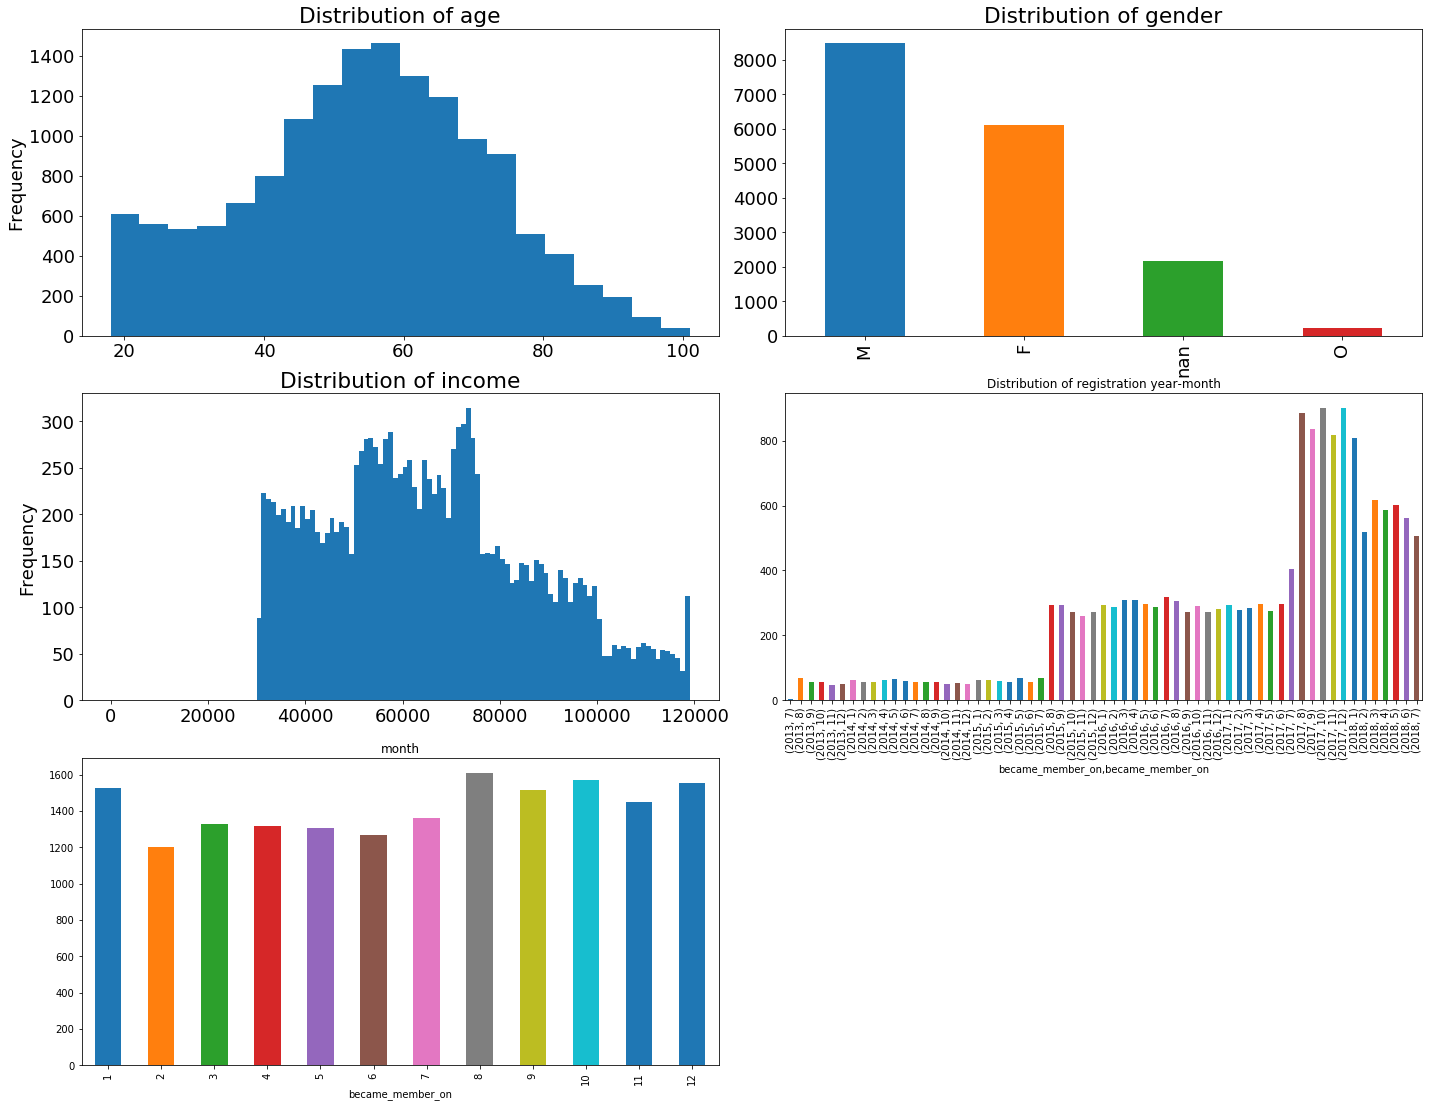

In [20]:
plt.rcParams["font.size"] = 18
plt.tight_layout()

plt.figure(figsize=[20,15])
plt.subplot(3,2,1)
plt.title("Distribution of age")
profile2.age.plot("hist", bins=20)
plt.subplot(3,2,2)
plt.title("Distribution of gender")
profile.gender.value_counts(dropna=False).plot(kind="bar")
plt.subplot(3,2,3)
plt.title("Distribution of income")
profile.income.plot("hist", bins=np.arange(0,profile2.income.max(),1000))

plt.rcParams["font.size"] = 10
plt.tight_layout()
plt.subplot(3,2,4)
plt.title("Distribution of registration year-month")
profile2.groupby([profile2.became_member_on.dt.year, profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar")

plt.subplot(3,2,5)
plt.title("month")
profile2.groupby([profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar");

#### distribution of year when a customer became a member

In [21]:
profile2.became_member_on.dt.year.value_counts()

2017    6469
2018    4198
2016    3526
2015    1830
2014     691
2013     286
Name: became_member_on, dtype: int64

## (3) transcript

In [22]:
# Take a look at a customer's all events in a month
transcript2[transcript2.person == "db691240326b44d8bfa7b438c4c41982"]

,event,person,time,transaction,id
1400,offer received,db691240326b44d8bfa7b438c4c41982,0,NaN,bogo_5days$10
12967,transaction,db691240326b44d8bfa7b438c4c41982,0,0.05,NaN
28037,offer viewed,db691240326b44d8bfa7b438c4c41982,42,NaN,bogo_5days$10
29685,transaction,db691240326b44d8bfa7b438c4c41982,48,1.70,NaN
32764,transaction,db691240326b44d8bfa7b438c4c41982,60,1.67,NaN
38366,transaction,db691240326b44d8bfa7b438c4c41982,84,2.44,NaN
43355,transaction,db691240326b44d8bfa7b438c4c41982,108,3.15,NaN
54583,offer received,db691240326b44d8bfa7b438c4c41982,168,NaN,disc_10days$20-$5
106022,transaction,db691240326b44d8bfa7b438c4c41982,306,0.45,NaN
112222,offer received,db691240326b44d8bfa7b438c4c41982,336,NaN,disc_10days$10-$2


In [23]:
transcript2.describe()

,time,transaction
count,306534.000000,138953.000000
mean,366.382940,12.777356
std,200.326314,30.250529
min,0.000000,0.050000
25%,186.000000,2.780000
50%,408.000000,8.890000
75%,528.000000,18.070000
max,714.000000,1062.280000


#### Distribution of customers' events which occurred / Distribution of types of coupons sent to customers

This suggests that 
around 75% of coupons sent to customers are viewed, and
around 75% of coupons sent to customers are completed.

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

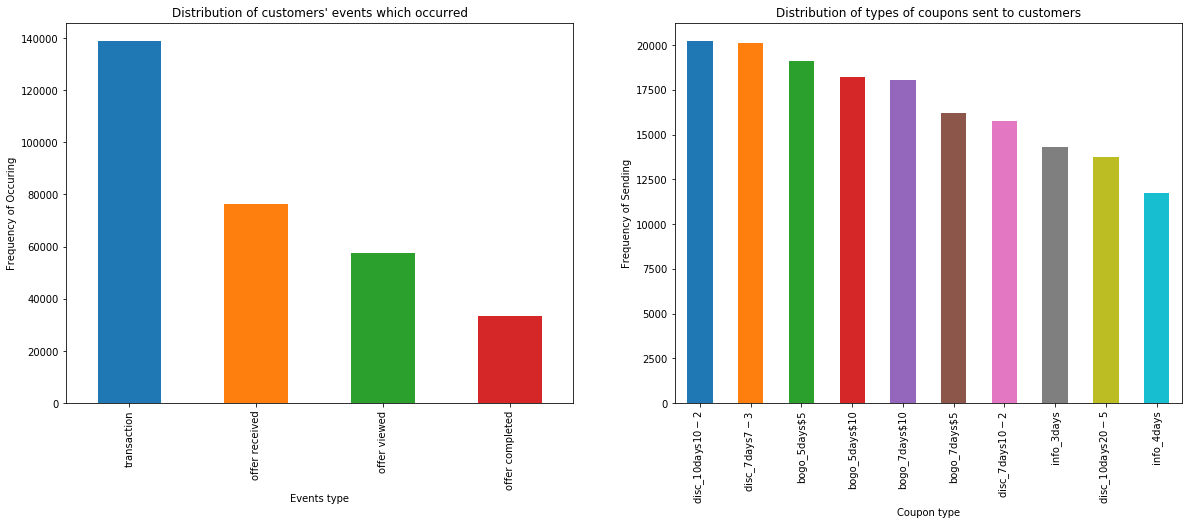

In [24]:
plt.figure(figsize=[20,7])

# Distribution of  of events
plt.subplot(1,2,1)
plt.title("Distribution of customers' events which occurred")
plt.xlabel("Events type")
plt.ylabel("Frequency of Occuring")
transcript2.event.value_counts().plot("bar")


# Distribution of offers issued
plt.subplot(1,2,2)
transcript2.merge(portfolio2, on="id").id.value_counts().plot("bar")
plt.title("Distribution of types of coupons sent to customers")
plt.xlabel("Coupon type")
plt.ylabel("Frequency of Sending")

transcript2.event.value_counts()

#### Distribution of amount of money spent in 1 transaction.

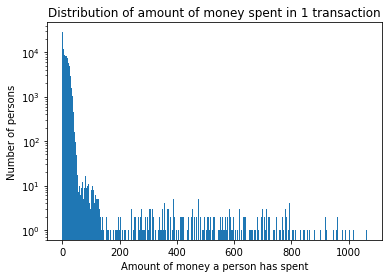

In [25]:
# Distribution of the amount of each of 138953 transactions
plt.title("Distribution of amount of money spent in 1 transaction")
plt.yscale("log")
transcript2.transaction.plot("hist", bins=500);
plt.xlabel("Amount of money a person has spent")
plt.ylabel("Number of persons");

#### monthly total transaction amount of each customer

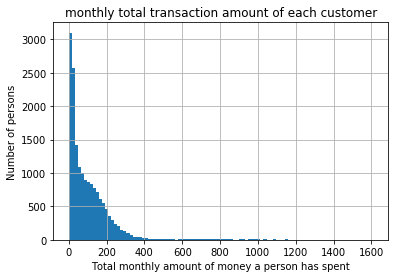

In [26]:
# Distribution of monthly total transaction amount by a customer
plt.title("monthly total transaction amount of each customer")
transcript2.groupby("person")["transaction"].sum().hist(bins=100)
plt.xlabel("Total monthly amount of money a person has spent")
plt.ylabel("Number of persons");

**I noticed that minimum transaction amount is $0.05. I will take a look at them below.**  

In [27]:
transcript2[transcript2.transaction == 0.05].sample(5)

,event,person,time,transaction,id
226019,transaction,349c817d5ca24c72953948c5180cd3d3,522,0.05,NaN
171814,transaction,9680c2c9be554bb6bbafe9dbc06b1be4,420,0.05,NaN
178335,transaction,8548baf4011c4e8b848d19cbe4010cfa,432,0.05,NaN
239552,transaction,5d26e4cc7a9c47af96abca48de7745d9,558,0.05,NaN
261398,transaction,af5e9b05867542b2a92e547f919d2bea,576,0.05,NaN


**Little Check of when this too little amount of transactions are made.**
And I could not find any dependency on time. This should be investigated better by communicating with data engineers and fellows from the marketing department.

Text(0,0.5,'Frequency of Sending')

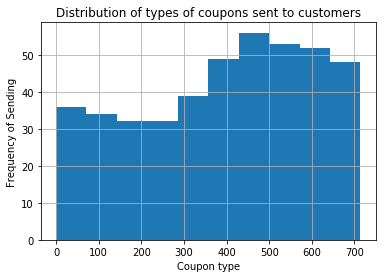

In [28]:
# When are the transactions of only $0.05 done
transcript2[transcript2.transaction == 0.05].time.hist()
plt.title("Distribution of types of coupons sent to customers")
plt.xlabel("Coupon type")
plt.ylabel("Frequency of Sending")

#### The graph below represents the time gap of customers from [time when they receive a coupon] to [time when they complete the coupon / time when they complete the coupon]. 

These suggests that when the time spent till the coupons are viewed (if they are viewed) distributes in the right-tailed manner. Same thing can be said on the time spent till completed.

Basically, offers are issued on **day 0, 7, 14, 17, 21, 24**. This means

* Offers which are valid for 10 days since day21
* Offers which are valid for 7,10 days since day24

expires after the end of observation period.
 
It should be better to remove these offer result later, but if there is a bias in these offers(i.e. Offers for young women are issued on day 24 mainly), the sample for a specific demographic for a specific type of offer would be significantly small. This can be checked more strictly as necessary...

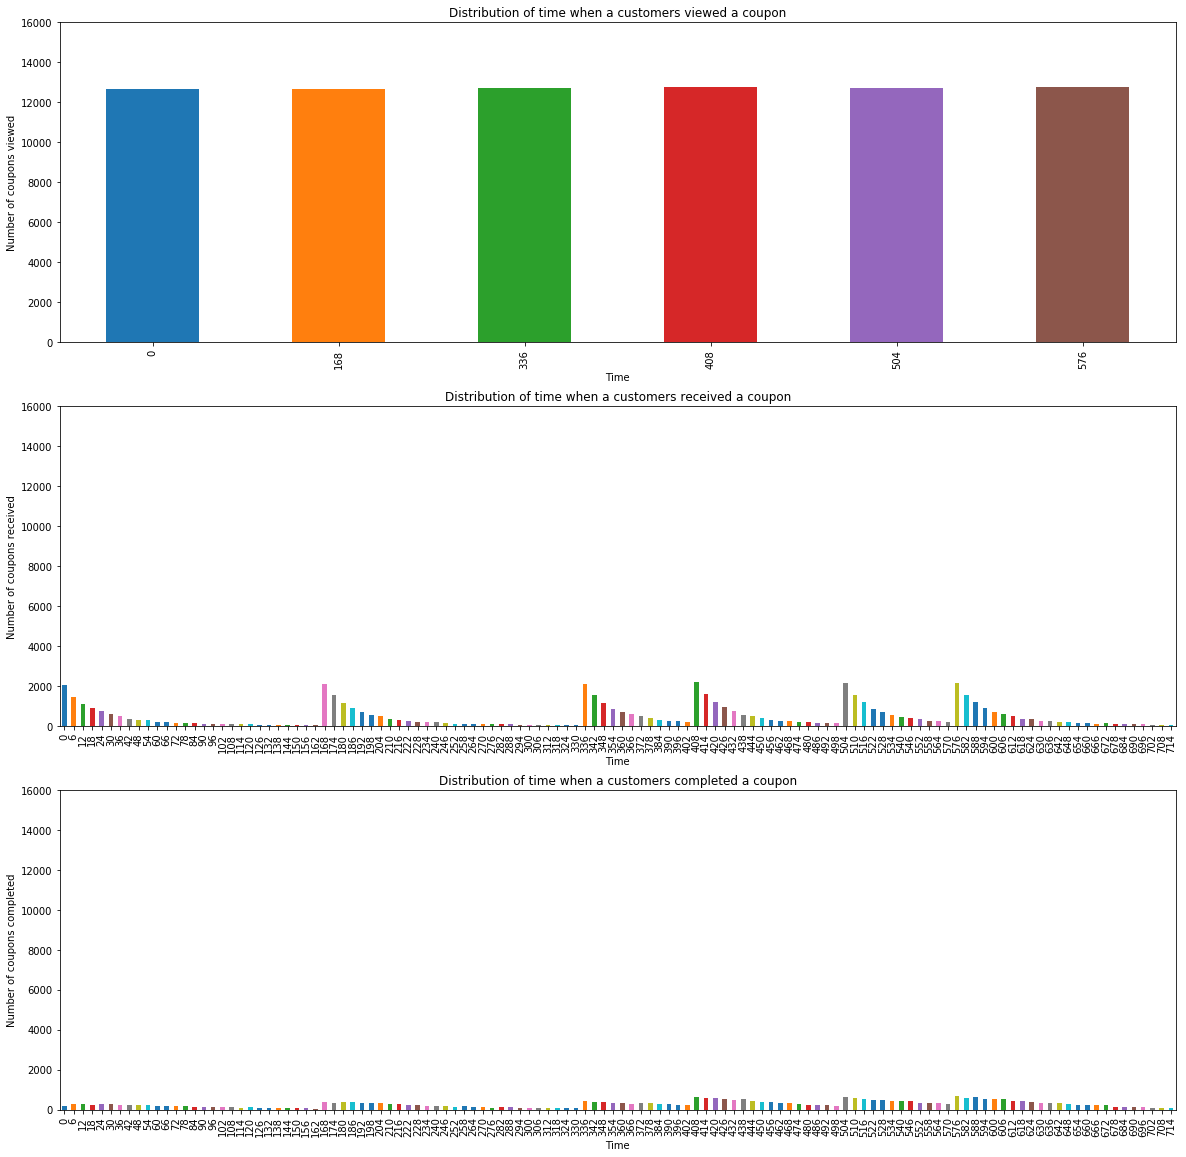

In [29]:
# Distribution of hour of transactions
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.xlim([0,714])
plt.ylim([0,16000])
transcript2[transcript2.event == "offer received"].time.value_counts().sort_index().plot("bar")
plt.title("Distribution of time when a customers viewed a coupon")
plt.xlabel("Time")
plt.ylabel("Number of coupons viewed")

# Distribution of hours when offer_received
plt.subplot(3,1,2)
plt.ylim([0,16000])
transcript2[transcript2.event == "offer viewed"].time.value_counts().sort_index().plot("bar")
plt.title("Distribution of time when a customers received a coupon")
plt.xlabel("Time")
plt.ylabel("Number of coupons received")

# Distribution of hours when offer_completed
plt.subplot(3,1,3)
plt.ylim([0,16000])
transcript2[transcript2.event == "offer completed"].time.value_counts().sort_index().plot("bar")
plt.title("Distribution of time when a customers completed a coupon")
plt.xlabel("Time")
plt.ylabel("Number of coupons completed");

#### And for reference, 6 persons had no transaction.

In [30]:
# persons received no transaction.
transcript2.groupby("person").id.count()[transcript2.groupby("person").id.count() == 0]

person
12ede229379747bd8d74ccdc20097ca3    0
3a4874d8f0ef42b9a1b72294902afea9    0
ae8111e7e8cd4b60a8d35c42c1110555    0
c6e579c6821c41d1a7a6a9cf936e91bb    0
da7a7c0dcfcb41a8acc7864a53cf60fb    0
eb540099db834cf59001f83a4561aef3    0
Name: id, dtype: int64

## Multivariate Exploration

I visualize customers in scatter plots based on 3 attributes [gender(male, female, other) vs. age(x-axis), imcome(y-axis)] below.

This suggests that some main clusters of starbucks inclueds

1. 20-60 aged, low-income male cluster
2. 50-70 aged, high-income female cluster

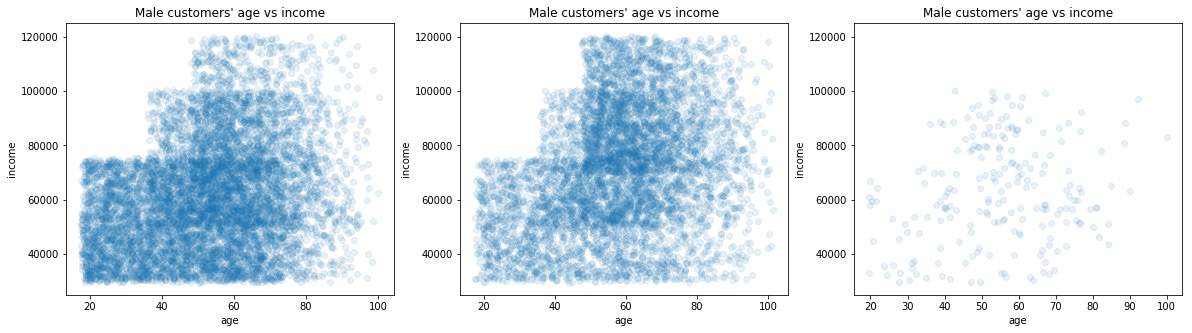

In [31]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
plt.title("Male customers' age vs income")
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_M == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.1}, fit_reg=False);


plt.subplot(1,3,2)
plt.title("Male customers' age vs income")
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_F == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.1}, fit_reg=False);


plt.subplot(1,3,3)
plt.title("Male customers' age vs income")
plt.ylim([25000,125000])
male_profile = profile2[profile2.gender_O == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.1}, fit_reg=False);

# 5. Make a dataframe whose each row represents each coupon (BOGO or Discount) sent in this observation period

In [32]:
portfolio2

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,bogo_7days$10,bogo,10
1,"[web, email, mobile, social]",10,5,bogo_5days$10,bogo,10
2,"[web, email, mobile]",0,4,info_4days,informational,0
3,"[web, email, mobile]",5,7,bogo_7days$5,bogo,5
4,"[web, email]",20,10,disc_10days$20-$5,discount,5
5,"[web, email, mobile, social]",7,7,disc_7days$7-$3,discount,3
6,"[web, email, mobile, social]",10,10,disc_10days$10-$2,discount,2
7,"[email, mobile, social]",0,3,info_3days,informational,0
8,"[web, email, mobile, social]",5,5,bogo_5days$5,bogo,5
9,"[web, email, mobile]",10,7,disc_7days$10-$2,discount,2


In [33]:
# extract row of "offer received" only of BOGO or DISCOUNT
offer_rec = transcript2[(transcript2.event == "offer received") & (transcript2.id.str[:4].isin(["bogo","disc"]))]
print(offer_rec.shape)

(61042, 5)


In [34]:
# remove 10 days offer which issued on day21(hour504)
offer_rec = offer_rec[~ ((offer_rec.time == 504) & (offer_rec.id.isin(["disc_10days$20-$5","disc_10days$10-$2"])))]
print(offer_rec.shape)

# remove 7 days offer which issued on day24
offer_rec = offer_rec[~ ((offer_rec.time == 576) & ~(offer_rec.id.isin(["bogo_7days$10","bogo_7days$5","disc_7days$7-$3","disc_7days$10-$2"])))]
print(offer_rec.shape)

# remove 10 days offer which issued on day24
offer_rec = offer_rec[~ ((offer_rec.time == 576) & ~(offer_rec.id.isin(["disc_10days$20-$5","disc_10days$10-$2"])))]
print(offer_rec.shape)

offer_rec.head()

(58501, 5)
(53463, 5)
(48326, 5)


,event,person,time,transaction,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,bogo_7days$5
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,disc_10days$20-$5
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,disc_7days$10-$2
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,disc_10days$10-$2
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,bogo_5days$10


In [35]:
offer_rec2 = offer_rec[:]

In [36]:
offer_interaction = pd.DataFrame(columns=["person","age","income","became_member_on","offer_id","t_received","t_viewed","amt_till_viewed","t_completed","amt_till_completed"], index=offer_rec2.index)
offer_interaction[["person","t_received","offer_id"]] = offer_rec2[["person","time","id"]]

offer_interaction.head()

,person,age,income,became_member_on,offer_id,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,NaN,NaN,NaN,bogo_7days$5,0,NaN,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,disc_10days$20-$5,0,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,NaN,NaN,NaN,disc_7days$10-$2,0,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,disc_10days$10-$2,0,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,bogo_5days$10,0,NaN,NaN,NaN,NaN


In [37]:
def from_id_to_duration(id):
    return portfolio2[portfolio2.id == id].duration.iloc[0] * 24

In [38]:
offer_rec2.shape

(48326, 5)

**time to run the cell below**  
4s for 100recs  
42s for 1000 recs  
207s for 5000 recs  
1976s for 48326 offer rec events

In [39]:
t = time.time()

# elapsed hours till the offer is viewed / completed
viewed_times = []
completed_times = []

# amount of purchase till the offer is viewed
amt_till_viewed = []
amt_till_completed = []

# for each offer received events...
for each_person, each_time, each_id in zip(offer_rec2.person, offer_rec2.time, offer_rec2.id):
    
    this_person_events = transcript2[(transcript2.person == each_person) & (each_time <= transcript2.time) & 
                             (transcript2.time <= each_time + from_id_to_duration(each_id))]
    
    #& (transcript2.id == each_id)
       
       
       
    # about offer viewed...
    viewed_row = this_person_events[(this_person_events.event == "offer viewed") &
                             (this_person_events.id == each_id)]
                             #(each_time <= this_person_events.time) & 
                             #(this_person_events.time <= each_time + from_id_to_duration(each_id))                          
    
    try:
        viewed_time = viewed_row.iloc[0].time
        viewed_times.append(viewed_time - each_time)
        
        trans_events = this_person_events[(this_person_events.event == "transaction") &
                            # (this_person_events.id == each_id)] 
                            # transaction does not have offer_id
                            #(each_time <= this_person_events.time) & 
                             (this_person_events.time <= viewed_time)]
        
        if (trans_events.shape[0] == 0):
            amt_till_viewed.append(0)
        else:
            amt_till_viewed.append(trans_events.transaction.sum())
            
    except Exception as e:
        #print(e)
        viewed_times.append(np.nan)
        amt_till_viewed.append(np.nan)
        
        
       
    # about offer completed....
    completed_row = this_person_events[(this_person_events.event == "offer completed") &
                             (this_person_events.id == each_id)]
                             #(each_time <= this_person_events.time) & 
                             #(this_person_events.time <= each_time + from_id_to_duration(each_id))
                            #]
        
    try:
        completed_time = completed_row.iloc[0].time
        completed_times.append(completed_time - each_time)
        
        trans_events = this_person_events[(this_person_events.event == "transaction") & 
                                         #(each_time <= this_person_events.time) & 
                                         (this_person_events.time <= completed_time)]
        
        if (trans_events.shape[0] == 0):
            amt_till_completed.append(0)
        else:
            amt_till_completed.append(trans_events.transaction.sum())
    except Exception as e:
        #print(e)
        completed_times.append(np.nan)
        amt_till_completed.append(np.nan)
        
        
offer_interaction.t_viewed = viewed_times
offer_interaction.amt_till_viewed = amt_till_viewed

       
offer_interaction.t_completed = completed_times
offer_interaction.amt_till_completed = amt_till_completed

print("{}s for {} offer rec events".format(round(time.time() - t), offer_rec2.shape[0]))

1999s for 48326 offer rec events


In [40]:
def person_to_attributes(person_id):
    return profile2[profile2.id == person_id].iloc[0][["age","gender_F","gender_M","gender_O","income","became_member_on"]]

In [41]:
offer_interaction[["age","gender_F","gender_M","gender_O","income","became_member_on"]] = offer_interaction.person.apply(person_to_attributes)
offer_interaction.became_member_on = pd.to_datetime(offer_interaction.became_member_on, format="%Y%m%d")

## 6. Basic Feature Engineering

Here, I will make a basic feature engineering.
1. Transform the column "became_member_on" according to [this post](https://stats.stackexchange.com/questions/311494/best-practice-for-encoding-datetime-in-machine-learning).
2. Merge the columns which represents sent offers' characteristics from "portfolio".
3. Extract rows where a customer firstly viewed a coupon.

In [46]:
##1. Transform the column "became_member_on" according to [this post]

import math

offer_interaction["became_year"] = offer_interaction.became_member_on.dt.year
offer_interaction["became_month_sin"] = (2 * math.pi * offer_interaction.became_member_on.dt.month / 12).apply(lambda x : math.sin(x))
offer_interaction["became_month_cos"] = (2 * math.pi * offer_interaction.became_member_on.dt.month / 12).apply(lambda x : math.cos(x))
offer_interaction["became_day_sin"] =   (2 * math.pi * offer_interaction.became_member_on.dt.day / 31).apply(lambda x : math.sin(x))
offer_interaction["became_day_cos"] =   (2 * math.pi * offer_interaction.became_member_on.dt.day / 31).apply(lambda x : math.cos(x))

offer_interaction["became_dow_sin"] = (2 * math.pi * offer_interaction.became_member_on.dt.dayofweek / 7).apply(lambda x : math.sin(x))
offer_interaction["became_dow_cos"] = (2 * math.pi * offer_interaction.became_member_on.dt.dayofweek / 7).apply(lambda x : math.cos(x))

In [47]:
## 2. Merge the columns which represents sent offers' characteristics from "portfolio

def from_offer_id_to_series(id):
    offer = portfolio2[portfolio2.id == id].iloc[0]
    return_s = pd.Series(0, index=["offer_bogo","offer_disc","difficulty","duration","reward",
                          "email","mobile","social","web"])
    for each_c in offer.channels: 
        return_s[each_c] = 1
    
    if offer.offer_type == "bogo":
        return_s.offer_bogo = 1
    elif offer.offer_type == "discount":
        return_s.offer_disc = 1
    
    return_s.difficulty = offer.difficulty
    return_s.duration = offer.duration
    return_s.reward = offer.reward
        
    
        
    return return_s

In [48]:
offer_interaction[["offer_bogo","offer_disc","difficulty","duration","reward","email","mobile","social","web"]] = \
                    offer_interaction.offer_id.apply(from_offer_id_to_series)

In [53]:
# "offer_interaction"'s each row represents each offer sent to customers.

print(offer_interaction.shape)
offer_interaction.head()

(48326, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,0.500000,-8.660254e-01,0.968077,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.0,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,-5.000000e-01,0.724793,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,0.866025,-5.000000e-01,-0.848644,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,5.000000e-01,0.394356,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.0,NaN,NaN


In [54]:
# save this dataframe in a file.
offer_interaction.to_csv("data/interaction.csv", index=False)

In [57]:
# reload the dataframe
offer_interaction2 = pd.read_csv("data/interaction.csv")

In [58]:
## 3. Extract rows where a customer firstly viewed a coupon.

# remove the offers which are not viewed
offer_viewed = offer_interaction2[~offer_interaction2.t_viewed.isnull()]
# remove the offers which are viewed after completeded (Note that 24 > null ==> null)
offer_viewed = offer_viewed[~(offer_viewed.t_viewed >= offer_viewed.t_completed)]

In [59]:
print(offer_viewed.shape)
offer_viewed.head()

(32007, 27)


,person,age,income,gender_F,gender_M,gender_O,became_year,became_month_sin,became_month_cos,became_day_sin,became_day_cos,became_dow_sin,became_dow_cos,offer_bogo,offer_disc,difficulty,duration,reward,email,mobile,social,web,t_received,t_viewed,amt_till_viewed,t_completed,amt_till_completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,1.0,0.0,0.0,2017,0.500000,-8.660254e-01,0.968077,-0.250653,0.781831,0.623490,1,0,5,7,5,1,1,0,1,0,6.0,0.0,132.0,19.89
1,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,-5.000000e-01,0.724793,0.688967,-0.433884,-0.900969,0,1,20,10,5,1,0,0,1,0,6.0,0.0,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,68.0,70000.0,0.0,1.0,0.0,2018,0.866025,-5.000000e-01,-0.848644,0.528964,0.433884,-0.900969,0,1,10,7,2,1,1,0,1,0,18.0,0.0,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,NaN,NaN,NaN,NaN,2017,-1.000000,-1.836970e-16,-0.937752,0.347305,0.000000,1.000000,0,1,10,10,2,1,1,1,1,0,12.0,0.0,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,NaN,NaN,NaN,NaN,NaN,2017,-0.866025,5.000000e-01,0.394356,0.918958,0.000000,1.000000,1,0,10,5,10,1,1,1,1,0,84.0,0.0,NaN,NaN


In [60]:
offer_viewed.to_csv("data/firstly_viewed_offers.csv", index=False)